In [1]:
# import libraries
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


/tmp/ipykernel_4011/2929204530.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Data

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')


# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2


# Class Definitions

In [3]:
class IrisClassifierModel(nn.Module):
    def __init__(self, _in, _out, depth=1, _params=None):
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(_in, _out)] if depth == 1 else [nn.Linear(_in, _params)] +
            [nn.Linear(_params, _params)]*(depth-2) +
            [nn.Linear(_params, _out)]
        )

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x)


In [4]:
class IrisClassifier():
    def __init__(self, data, labels, lr,  numepochs, depth=1, _params=None, train_size=.8, batch_size=1):
        # model architecture
        self.lr = lr
        self.numepochs = numepochs
        self.model = IrisClassifierModel(4, 3, depth, _params)
        # loss function
        self.lossfun = nn.CrossEntropyLoss()
        # optimizer
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=.01)
        self.trainaccs = torch.zeros(numepochs)
        self.testaccs = torch.zeros(numepochs)

        trainData, testData, trainLabels, testLabels = train_test_split(
            data, labels, train_size=train_size)
        # self.split(data, labels, train_size)
        trainData = TensorDataset(torch.tensor(
            trainData), torch.tensor(trainLabels))
        testData = TensorDataset(torch.tensor(
            testData), torch.tensor(testLabels))

        self.numOfBatches = len(trainLabels) // batch_size
        self.trainLoader = DataLoader(trainData, batch_size=batch_size)
        self.testLoader = DataLoader(testData, batch_size=len(testLabels))

    def train(self):
        # initialize losses
        self.losses = torch.zeros(self.numepochs)
        for epochi in range(self.numepochs):
            batchacc = torch.zeros(self.numOfBatches)
            batchloss = torch.zeros(self.numOfBatches)
            batchIter = 0
            self.model.train()
            for X, y in self.trainLoader:
                # forward pass
                yHat = self.model(X)

                # compute loss
                loss = self.lossfun(yHat, y)
                batchloss[batchIter] = loss

                # backprop
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                batchacc[batchIter] = self.getAcc(yHat, y)
                batchIter += 1

            self.losses[epochi] = torch.mean(batchloss)
            # compute accuracy
            self.trainaccs[epochi] = torch.mean(batchacc)

            X, y = next(iter(self.testLoader))
            self.testaccs[epochi] = self.eval(X, y)
        return self.trainaccs, self.testaccs, self.losses

    def split(self, data, labels, partitions):
        """ partitions: order is train,devset,test. It can be either a list of 2 or 3 elements """
        # split the data (note the third input, and the TMP in the variable name)
        train_data, testTMP_data, train_labels, testTMP_labels = train_test_split(data, labels, train_size=partitions[0])

        # now split the TMP data
        split = partitions[1] / (1-partitions[0])
        devset_data, test_data, devset_labels, test_labels = train_test_split(testTMP_data, testTMP_labels, train_size=split)
        return train_data, devset_data, test_data, train_labels, devset_labels, test_labels

    def getAcc(self, preds, labels):
        return 100*torch.mean((torch.argmax(preds, axis=1) == labels).float())

    def eval(self, data, labels):
        self.model.eval()
        with torch.inference_mode():
            # final forward pass
            self.predictions = self.model.forward(data)
            self.totalacc = self.getAcc(self.predictions, labels)
            return self.totalacc

    def print(self):
        for name, param in self.model.named_parameters():
            print(name, param.shape)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))

    def save(self, path):
        torch.save(self.model.state_dict(), path)


In [5]:
def factorsList(N):
    arr = torch.arange(1,N+1)
    return arr[N % arr == 0]

In [6]:
NUMEPOCHS = 500
batchSizes = factorsList(120)
trainaccs = torch.zeros(len(batchSizes), NUMEPOCHS)
testaccs = torch.zeros(len(batchSizes), NUMEPOCHS)
for j, batchSize in enumerate(batchSizes):
    classifier = IrisClassifier(
        data, labels, .01,  NUMEPOCHS, 3, 16, .8, int(batchSize.item()))
    trainaccs[j, :], testaccs[j, :], _ = classifier.train()


/tmp/ipykernel_4011/1603831106.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainData = TensorDataset(torch.tensor(
/tmp/ipykernel_4011/1603831106.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainData), torch.tensor(trainLabels))
/tmp/ipykernel_4011/1603831106.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testData = TensorDataset(torch.tensor(
/tmp/ipykernel_4011/1603831106.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

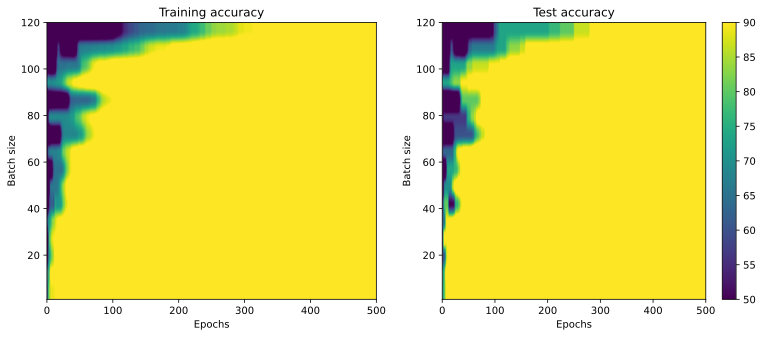

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].imshow(trainaccs, aspect='auto', origin="lower",
             vmin=50, vmax=90, extent=[0, NUMEPOCHS, batchSizes[0], batchSizes[-1]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Batch size')
ax[0].set_title('Training accuracy')

p = ax[1].imshow(testaccs, aspect='auto', origin="lower",
                 vmin=50, vmax=90, extent=[0, NUMEPOCHS, batchSizes[0], batchSizes[-1]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Batch size')
ax[1].set_title('Test accuracy')
fig.colorbar(p, ax=ax[1])

plt.show()


In [15]:
def argmax2d(accs):
    amax = torch.argmax(accs)
    denom = accs.shape[1]
    x = amax%denom
    y = amax//denom
    return x, y

In [16]:
print(argmax2d(trainaccs))
print(argmax2d(testaccs))

(tensor(119), tensor(8))
(tensor(2), tensor(3))


/tmp/ipykernel_4011/2147834181.py:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y = amax//denom


In [20]:
NUMEPOCHS = 500
classifier = IrisClassifier(
        data, labels, .01,  NUMEPOCHS, 3, 16, .8, 1)
trainacc, testacc, _ = classifier.train()
classifier.totalacc

/tmp/ipykernel_4011/1603831106.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainData = TensorDataset(torch.tensor(
/tmp/ipykernel_4011/1603831106.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainData), torch.tensor(trainLabels))
/tmp/ipykernel_4011/1603831106.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testData = TensorDataset(torch.tensor(
/tmp/ipykernel_4011/1603831106.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

tensor(96.6667)

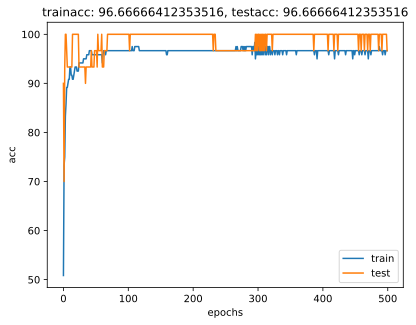

In [21]:

plt.plot(np.arange(len(trainacc)), trainacc)
plt.plot(np.arange(len(testacc)), testacc)
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend(["train", "test"])
plt.title(f"trainacc: {trainacc[-1]}, testacc: {testacc[-1]}")

plt.show()

In [ ]:
# NUMEPOCHS = 500
# trainSizes = np.linspace(.2, .95, 10)
# trainaccs = torch.zeros(len(trainSizes), NUMEPOCHS)
# testaccs = torch.zeros(len(trainSizes), NUMEPOCHS)

# for j in range(len(trainSizes)):
#     classifier = IrisClassifier(
#         data, labels, .01,  NUMEPOCHS, 3, 16, trainSizes[j])
#     trainaccs[j, :], testaccs[j, :], _ = classifier.train()


In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# ax[0].imshow(trainaccs, aspect='auto',
#              vmin=50, vmax=90, extent=[0, NUMEPOCHS, trainSizes[0], trainSizes[-1]])
# ax[0].set_xlabel('Epochs')
# ax[0].set_ylabel('Training size proportion')
# ax[0].set_title('Training accuracy')

# p = ax[1].imshow(testaccs, aspect='auto',
#                  vmin=50, vmax=90, extent=[0, NUMEPOCHS, trainSizes[0], trainSizes[-1]])
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Training size proportion')
# ax[1].set_title('Test accuracy')
# fig.colorbar(p, ax=ax[1])

# plt.show()


In [ ]:
trainData, testData, trainLabels, testLabels = train_test_split(
    data, labels, train_size=.8)


In [ ]:
trainData, testData, trainLabels, testLabels = classifier.split(
    data, labels, .8)
